# Segmenting, Clustering and Recommending to avoid bad choice of Neighborhoods for New Restaurants in Toronto

## 1. Install & Import Libraries

In [1]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge


In [2]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt
import seaborn as sns
import folium # map rendering library



import types
from botocore.client import Config
import ibm_boto3

print('Libraries imported.')

Libraries imported.


## 2. Read html using BeautifulSoup library

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M';
html = requests.get(url).text
soup = BeautifulSoup(html,'lxml')

In [4]:
# find the table
postal_codes_table = soup.find('table',{'class':'wikitable sortable'})

In [5]:
# extract td's only
table_cells = postal_codes_table.find_all('td')

In [6]:
# group each 3 cells together
N = 3
table_rows = [table_cells[n:n+N] for n in range(0, len(table_cells), N)]
postal_code = []
borough = []
neighborhood = []
for row in table_rows:
    postal_code_text = row[0].text
    borough_text = row[1].text
    neighborhood_text = row[2].text.rstrip('\n')
    if borough_text != 'Not assigned':
        postal_code.append(postal_code_text)
        borough.append(borough_text)
        neighborhood.append(neighborhood_text)

## 3. Create & Explore Dataset

In [7]:
df = pd.DataFrame()
df['PostalCode'] = postal_code
df['Borough'] = borough
df['Neighborhood'] = neighborhood
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [8]:
# group neighborhoods of the same postal code
df = df.groupby(['PostalCode','Borough']).aggregate(lambda x : ', '.join(x)).reset_index()
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [9]:
# check M5A 
df.loc[df['PostalCode'] == 'M5A']

,PostalCode,Borough,Neighborhood
53,M5A,Downtown Toronto,"Harbourfront, Regent Park"


In [10]:
# fill 'Not assigned' neighborhood to the proper borough
df.loc[df['Neighborhood'] == 'Not assigned', 'Neighborhood'] = df['Borough']

In [11]:
# check M5A 
df.loc[df['PostalCode'] == 'M7A']

,PostalCode,Borough,Neighborhood
85,M7A,Queen's Park,Queen's Park


data shape

In [12]:
# df shape
df.shape

(103, 3)

## Insert Geospatial Coordinates CSV file to the code

In [13]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_1f2743066d6b4a08862baaf50b794f6d = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='DaADxXD1xYXv4gPZuq9gM2enGDBpOTc_pftcgowbyk-C',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_1f2743066d6b4a08862baaf50b794f6d.get_object(Bucket='mydatascienceproject-donotdelete-pr-4no7swxe9h5vwt',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()



,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## Perform Left Join to the data frames.

In [14]:
df_data_1.rename(columns={'Postal Code':'PostalCode'},inplace=True)
df_data_1.head()
df = pd.merge(df, df_data_1, on='PostalCode', how='left')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [15]:
# check M5G 
df.loc[df['PostalCode'] == 'M5G']

,PostalCode,Borough,Neighborhood,Latitude,Longitude
57,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383


## Now let's create a map of Toronto with neighborhoods superimposed on top.

first, let's work with only borough that containts the name Toronto 

In [16]:
#df = df[df['Borough'].str.contains("Toronto")].reset_index()
#df.head()

Geograpical coordinate of Toronto

In [17]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [18]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186c0',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

## 4. Explore Neighborhoods

Define Foursquare Credentials and Version

In [19]:
CLIENT_ID = 'B2CWZ3L4M04KBQOBSR0JDVTDGVCDFFW0EVYKBBZL5JVVXWFJ' # your Foursquare ID
CLIENT_SECRET = 'WNG3ODIQUSFPIQ0DEJGDJJT5U0TSJA1KOCARDPQSVR3IPDKC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Let's explore the first neighborhood

In [20]:
df.loc[0, 'Neighborhood']

'Rouge, Malvern'

#### get latitude and longitude of the neighborhood

In [21]:
neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Rouge, Malvern are 43.806686299999996, -79.19435340000001.


#### Now, let's get the top 100 venues that are within a radius of 500 meters.

In [22]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

# get resullt
results = requests.get(url).json()

In [23]:
results

{'meta': {'code': 200, 'requestId': '5caa60ca4434b90ed144dd28'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4bb6b9446edc76b0d771311c-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d16e941735',
         'name': 'Fast Food Restaurant',
         'pluralName': 'Fast Food Restaurants',
         'primary': True,
         'shortName': 'Fast Food'}],
       'id': '4bb6b9446edc76b0d771311c',
       'location': {'cc': 'CA',
        'city': 'Toronto',
        'country': 'Canada',
        'crossStreet': 'Morningside & Sheppard',
        'distance': 387,
        'formattedAddress': ['Toronto ON', 'Canada'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.80744841934756,
          'ln

Let's create a function that extracts the category of the venue

In [24]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Now let's clean the json and structure it into a *pandas* dataframe.

In [25]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.id', 'venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,id,name,categories,lat,lng
0,4bb6b9446edc76b0d771311c,Wendy's,Fast Food Restaurant,43.807448,-79.199056


### Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue Id',
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [28]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [29]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,4bb6b9446edc76b0d771311c,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,4c23d3aaf7ced13a5ed7216d,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,536bdf8f498ede143cca0072,Scarborough Historical Society,43.788755,-79.162438,History Museum
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4b6074e3f964a5200fe729e3,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4c62f34bde1b2d7fec89e370,G & G Electronics,43.765309,-79.191537,Electronics Store


venues per neighborhood

In [30]:
toronto_venues.groupby('Neighborhood').count()['Venue Id']

Neighborhood
Adelaide, King, Richmond                                                                                         100
Agincourt                                                                                                          4
Agincourt North, L'Amoreaux East, Milliken, Steeles East                                                           2
Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown     12
Alderwood, Long Branch                                                                                            10
Bathurst Manor, Downsview North, Wilson Heights                                                                   18
Bayview Village                                                                                                    4
Bedford Park, Lawrence Manor East                                                                                 24
Berczy Park                                        

#### Let's find out how many unique categories can be curated from all the returned venues

In [31]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 275 uniques categories.


### because our main goal is to recommend a neighborhood for a new restaurant, we need to filter our data, so we will have only venues categories that contains the word 'Restaurant'

In [32]:
toronto_venues = toronto_venues[toronto_venues['Venue Category'].str.contains("Restaurant")].reset_index()
toronto_venues.head()

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,0,"Rouge, Malvern",43.806686,-79.194353,4bb6b9446edc76b0d771311c,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,6,"Guildwood, Morningside, West Hill",43.763573,-79.188711,5411f741498e9ebd5e35d8bd,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
2,13,Woburn,43.770992,-79.216917,4de0403ed4c040523ea079f4,Korean Grill House,43.770812,-79.214502,Korean Restaurant
3,14,Cedarbrae,43.773136,-79.239476,4b1711a6f964a520cbc123e3,Federick Restaurant,43.774697,-79.241142,Hakka Restaurant
4,15,Cedarbrae,43.773136,-79.239476,4e261f261f6eb1ae13930699,Drupati's Roti & Doubles,43.775222,-79.241678,Caribbean Restaurant


### data shape

In [33]:
toronto_venues.shape

(514, 9)

let's plot veneus on the map

In [34]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


In [35]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'] , toronto_venues['Venue Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186c0',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Plot Category distribution

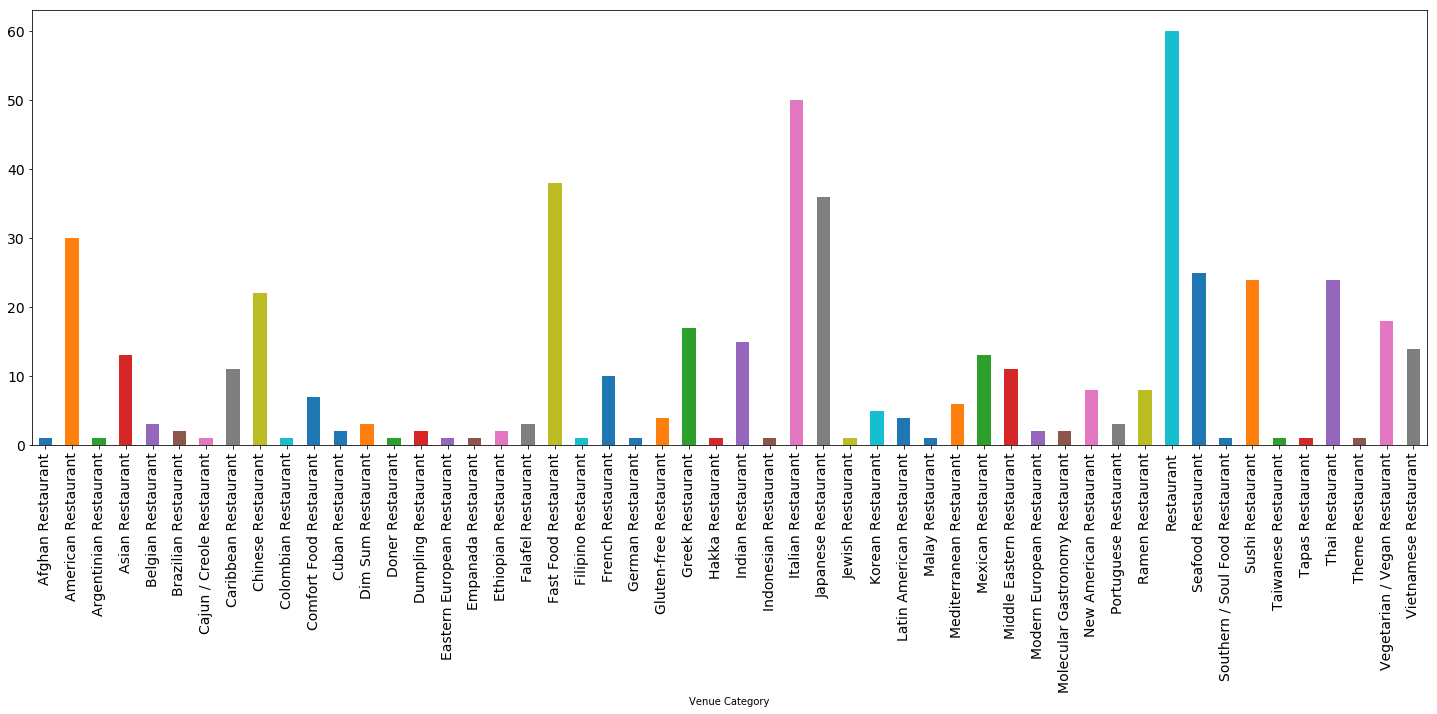

In [36]:
toronto_venues.groupby('Venue Category').size().plot.bar(figsize=(25,8), fontsize = 14)

## 5. Analyze Each Neighborhood

In [37]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']])

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Venue Category_Afghan Restaurant,Venue Category_American Restaurant,Venue Category_Argentinian Restaurant,Venue Category_Asian Restaurant,Venue Category_Belgian Restaurant,Venue Category_Brazilian Restaurant,Venue Category_Cajun / Creole Restaurant,Venue Category_Caribbean Restaurant,Venue Category_Chinese Restaurant,...,Venue Category_Restaurant,Venue Category_Seafood Restaurant,Venue Category_Southern / Soul Food Restaurant,Venue Category_Sushi Restaurant,Venue Category_Taiwanese Restaurant,Venue Category_Tapas Restaurant,Venue Category_Thai Restaurant,Venue Category_Theme Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Woburn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Cedarbrae,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cedarbrae,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Now, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [38]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Venue Category_Afghan Restaurant,Venue Category_American Restaurant,Venue Category_Argentinian Restaurant,Venue Category_Asian Restaurant,Venue Category_Belgian Restaurant,Venue Category_Brazilian Restaurant,Venue Category_Cajun / Creole Restaurant,Venue Category_Caribbean Restaurant,Venue Category_Chinese Restaurant,...,Venue Category_Restaurant,Venue Category_Seafood Restaurant,Venue Category_Southern / Soul Food Restaurant,Venue Category_Sushi Restaurant,Venue Category_Taiwanese Restaurant,Venue Category_Tapas Restaurant,Venue Category_Thai Restaurant,Venue Category_Theme Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant
0,"Adelaide, King, Richmond",0.0,0.111111,0.0,0.074074,0.0,0.037037,0.0,0.0,0.0,...,0.111111,0.037037,0.0,0.111111,0.0,0.0,0.148148,0.0,0.037037,0.0
1,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
2,"Bathurst Manor, Downsview North, Wilson Heights",0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.333333,0.000000,0.0,0.333333,0.0,0.0,0.000000,0.0,0.000000,0.0
3,Bayview Village,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.5,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.090909,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.090909,0.000000,0.0,0.090909,0.0,0.0,0.090909,0.0,0.000000,0.0


 let's confirm the new size

In [39]:
toronto_grouped.shape

(67, 53)

#### Let's print each neighborhood along with the top 5 most common cuisine restaurants

In [40]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['cuisine','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                              cuisine  freq
0      Venue Category_Thai Restaurant  0.15
1  Venue Category_American Restaurant  0.11
2     Venue Category_Sushi Restaurant  0.11
3           Venue Category_Restaurant  0.11
4  Venue Category_Japanese Restaurant  0.07


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                                cuisine  freq
0    Venue Category_Japanese Restaurant   0.5
1   Venue Category_Fast Food Restaurant   0.5
2      Venue Category_Afghan Restaurant   0.0
3  Venue Category_Indonesian Restaurant   0.0
4      Venue Category_Jewish Restaurant   0.0


----Bathurst Manor, Downsview North, Wilson Heights----
                                          cuisine  freq
0                 Venue Category_Sushi Restaurant  0.33
1             Venue Category_Fast Food Restaurant  0.33
2                       Venue Category_Restaurant  0.33
3                Venue Ca

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the cuisine restaurant in descending order.

In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 frequent cuisines for each neighborhood.

In [42]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top cuisine
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common cuisine'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common cuisine'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common cuisine,2nd Most Common cuisine,3rd Most Common cuisine,4th Most Common cuisine,5th Most Common cuisine
0,"Adelaide, King, Richmond",Venue Category_Thai Restaurant,Venue Category_American Restaurant,Venue Category_Sushi Restaurant,Venue Category_Restaurant,Venue Category_Japanese Restaurant
1,"Albion Gardens, Beaumond Heights, Humbergate, ...",Venue Category_Japanese Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Greek Restaurant,Venue Category_German Restaurant
2,"Bathurst Manor, Downsview North, Wilson Heights",Venue Category_Fast Food Restaurant,Venue Category_Sushi Restaurant,Venue Category_Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Dim Sum Restaurant
3,Bayview Village,Venue Category_Japanese Restaurant,Venue Category_Chinese Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Doner Restaurant,Venue Category_German Restaurant
4,"Bedford Park, Lawrence Manor East",Venue Category_Fast Food Restaurant,Venue Category_Italian Restaurant,Venue Category_Comfort Food Restaurant,Venue Category_American Restaurant,Venue Category_Thai Restaurant


## 6. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 10 clusters.

In [43]:
# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 3, 8, 3, 2, 2, 2, 8, 2, 1], dtype=int32)

add clustering labels

In [44]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Let's create a new dataframe that includes the cluster as well as the top 5 frequent cuisine for each neighborhood.

In [45]:
toronto_merged = neighborhoods_venues_sorted
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(df.set_index('Neighborhood'), on='Neighborhood').reset_index()
toronto_merged.tail() # check the last columns!

,index,Cluster Labels,Neighborhood,1st Most Common cuisine,2nd Most Common cuisine,3rd Most Common cuisine,4th Most Common cuisine,5th Most Common cuisine,PostalCode,Borough,Latitude,Longitude
62,62,2,Victoria Village,Venue Category_Portuguese Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Dim Sum Restaurant,Venue Category_German Restaurant,Venue Category_French Restaurant,M4A,North York,43.725882,-79.315572
63,63,4,Westmount,Venue Category_Chinese Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Doner Restaurant,Venue Category_German Restaurant,M9P,Etobicoke,43.696319,-79.532242
64,64,2,Willowdale South,Venue Category_Restaurant,Venue Category_Ramen Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Indonesian Restaurant,M2N,North York,43.770120,-79.408493
65,65,5,Woburn,Venue Category_Korean Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Greek Restaurant,Venue Category_German Restaurant,Venue Category_French Restaurant,M1G,Scarborough,43.770992,-79.216917
66,66,1,"Woodbine Gardens, Parkview Hill",Venue Category_Fast Food Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Gluten-free Restaurant,Venue Category_German Restaurant,M4B,East York,43.706397,-79.309937


### clusters sizes

In [46]:
toronto_merged.groupby('Cluster Labels').count()['Neighborhood']

Cluster Labels
0     4
1     6
2    38
3     5
4     4
5     1
6     1
7     1
8     4
9     3
Name: Neighborhood, dtype: int64

### Finally, let's visualize the resulting clusters

In [47]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [48]:
toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [49]:
toronto_grouped.tail()

,Cluster Labels,Neighborhood,Venue Category_Afghan Restaurant,Venue Category_American Restaurant,Venue Category_Argentinian Restaurant,Venue Category_Asian Restaurant,Venue Category_Belgian Restaurant,Venue Category_Brazilian Restaurant,Venue Category_Cajun / Creole Restaurant,Venue Category_Caribbean Restaurant,...,Venue Category_Restaurant,Venue Category_Seafood Restaurant,Venue Category_Southern / Soul Food Restaurant,Venue Category_Sushi Restaurant,Venue Category_Taiwanese Restaurant,Venue Category_Tapas Restaurant,Venue Category_Thai Restaurant,Venue Category_Theme Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant
62,2,Victoria Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
63,4,Westmount,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
64,2,Willowdale South,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.25,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.083333
65,5,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
66,1,"Woodbine Gardens, Parkview Hill",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [50]:
toronto_clusters = toronto_grouped.groupby('Cluster Labels').mean()

In [51]:
toronto_clusters

,Venue Category_Afghan Restaurant,Venue Category_American Restaurant,Venue Category_Argentinian Restaurant,Venue Category_Asian Restaurant,Venue Category_Belgian Restaurant,Venue Category_Brazilian Restaurant,Venue Category_Cajun / Creole Restaurant,Venue Category_Caribbean Restaurant,Venue Category_Chinese Restaurant,Venue Category_Colombian Restaurant,...,Venue Category_Restaurant,Venue Category_Seafood Restaurant,Venue Category_Southern / Soul Food Restaurant,Venue Category_Sushi Restaurant,Venue Category_Taiwanese Restaurant,Venue Category_Tapas Restaurant,Venue Category_Thai Restaurant,Venue Category_Theme Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant
Cluster Labels,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.133333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000907,0.053188,0.001316,0.044569,0.004468,0.002119,0.004386,0.024,0.034719,0.000975,...,0.109837,0.041317,0.001316,0.041440,0.002392,0.001316,0.047279,0.000907,0.027936,0.017074
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300,0.100000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.583333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.022727,0.000000,0.022727,0.000000,0.000000,0.000000,0.000,0.022727,0.000000,...,0.503788,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


let's examine each cluster by heatmap

In [52]:
toronto_clusters_trans = toronto_clusters.transpose()
toronto_clusters_trans.head()

Cluster Labels,0,1,2,3,4,5,6,7,8,9
Venue Category_Afghan Restaurant,0.0,0.0,0.000907,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
Venue Category_American Restaurant,0.0,0.0,0.053188,0.0,0.0,0.0,0.0,0.0,0.022727,0.444444
Venue Category_Argentinian Restaurant,0.0,0.0,0.001316,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
Venue Category_Asian Restaurant,0.0,0.0,0.044569,0.0,0.0,0.0,0.0,0.0,0.022727,0.000000
Venue Category_Belgian Restaurant,0.0,0.0,0.004468,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


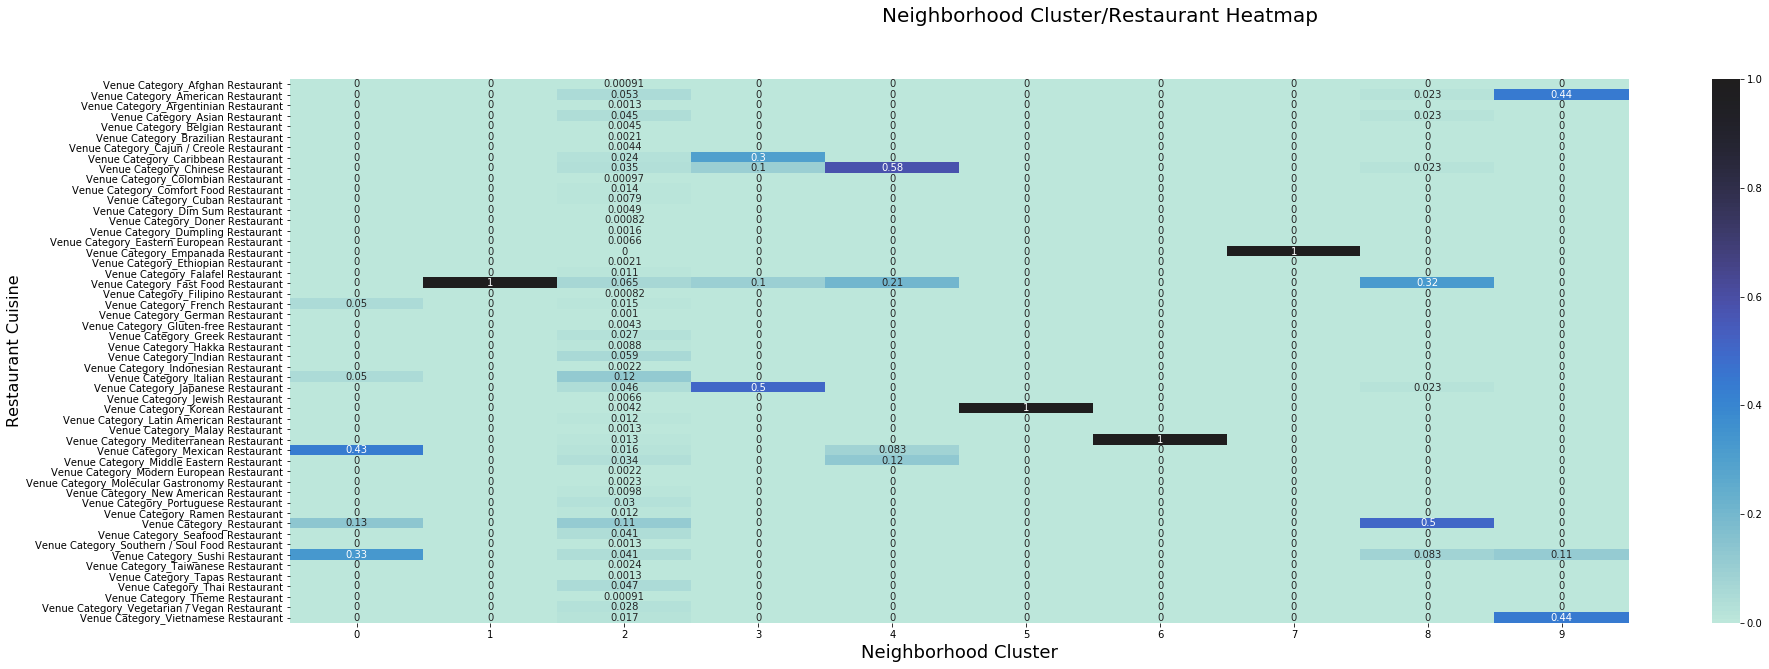

In [53]:
fig, ax = plt.subplots(figsize=(30,10))  
# plot heatmap

ax = sns.heatmap(toronto_clusters_trans, center=1, annot=True, ax=ax)

fig.suptitle('Neighborhood Cluster/Restaurant Heatmap', fontsize=20)
plt.xlabel('Neighborhood Cluster', fontsize=18)
plt.ylabel('Restaurant Cuisine', fontsize=16)
# save figure
plt.show()

## Dark color means that the restaurant cuisine is very common in the corresponding neighborhood cluster, for example if someone is willing to open a new Chinese Restaurant, we can recommend him where not to open his new restaurant.

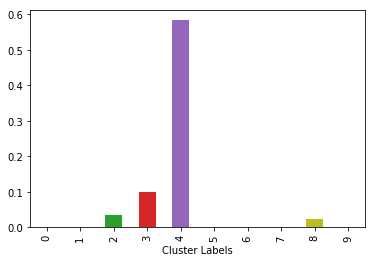

In [54]:
toronto_clusters_trans.loc['Venue Category_Chinese Restaurant'].plot(kind='bar')

## cluster 4 has a high frequent of Chinese restaurants, so try not to open a new chiense restaurant in cluster 4's neighborhoods. 